In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
import tensorflow.keras.utils as ku
import pickle

In [3]:
# open preprocessed texts
all_train = pd.read_csv("train_preprocess.csv")

# extract non-hateful comments
train = all_train.loc[all_train["hate_speech"] == 0][["preprocess"]]
train[["preprocess"]] = train[["preprocess"]].astype(str)

# prepare data for modeling

max_words = 30000
max_text_length = 300 # 300 is chosen based on the distribution of texts' length

# prepare tokenizer
tokenizer = Tokenizer(max_words)
tokenizer.fit_on_texts(train["preprocess"])

# convert text into arrays
train1 = tokenizer.texts_to_sequences(train["preprocess"])

# pad the sentences
train_final = pad_sequences(train1, max_text_length)

In [22]:
# define predictors and labels, we extract the last words of each comment as label
predictors, labels = train_final[:,:-1],train_final[:,-1]
# pad labels cause it's actually a classification problem
labels = ku.to_categorical(labels, num_classes = max_words)

In [23]:
# build embedding matrix
# open glove embedding
embedding_dim =100
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embeddings_index[word]= coefs
f.close()

# create embedding matrix
embedding_matrix = np.zeros((max_words,embedding_dim))
for word, index in tokenizer.word_index.items():
    if index > max_words-1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index]= embedding_vector

In [24]:
# build LSTM model
model = Sequential()
model.add(Embedding(max_words,
                    embedding_dim,
                    embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
                    trainable = False
                   ))
model.add(LSTM(units = embedding_dim, 
               dropout = 0.2, 
               recurrent_dropout = 0.2, 
               return_sequences=True
              ))
model.add(LSTM(units = embedding_dim, 
               dropout = 0.2, 
               recurrent_dropout = 0.2
              ))

model.add(Dense(max_words, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         3000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 100)         80400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 30000)             3030000   
Total params: 6,190,800
Trainable params: 3,190,800
Non-trainable params: 3,000,000
_________________________________________________________________


In [25]:
# compile model with data
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ["accuracy"])
result = model.fit(predictors, labels, 
                   batch_size = 32, 
                   epochs = 5, 
                  )

Epoch 1/5
4480/4480 [==============================] - 7073s 2s/step - loss: 8.0385 - accuracy: 0.0623
Epoch 2/5
4480/4480 [==============================] - 5115s 1s/step - loss: 7.2515 - accuracy: 0.0841
Epoch 3/5
4480/4480 [==============================] - 5147s 1s/step - loss: 6.9152 - accuracy: 0.0976
Epoch 4/5
4480/4480 [==============================] - 5165s 1s/step - loss: 6.6607 - accuracy: 0.1056
Epoch 5/5
4480/4480 [==============================] - 5134s 1s/step - loss: 6.4181 - accuracy: 0.1122


<Figure size 432x288 with 0 Axes>

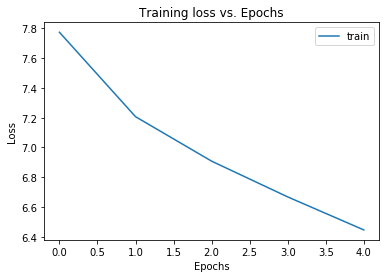

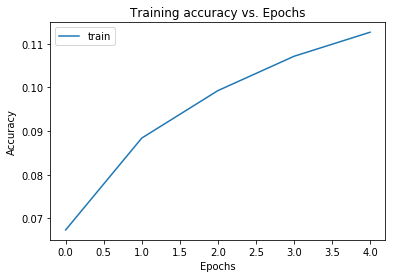

<Figure size 432x288 with 0 Axes>

In [28]:
plt.plot(result.history['loss'], label = 'train')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss vs. Epochs')
plt.legend()
plt.figure()
plt.plot(result.history['accuracy'], label = 'train')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs. Epochs')
plt.legend()
plt.figure()

In [ ]:
model.save('SpeechGenerator.h5')